<a href="https://colab.research.google.com/github/helgi17-gb/ImageProcessing/blob/master/%D0%A3%D1%84%D0%B0_contest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.metrics import roc_auc_score, roc_curve, auc , accuracy_score

In [2]:
!wget https://lodmedia.hb.bizmrg.com/case_files/758085/train_dataset_train.zip

--2022-07-03 20:50:31--  https://lodmedia.hb.bizmrg.com/case_files/758085/train_dataset_train.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 217.69.142.100
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|217.69.142.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101641284 (97M) [application/zip]
Saving to: ‘train_dataset_train.zip’

train_dataset_train 100%[===================>]  96.93M  21.2MB/s    in 4.6s    

2022-07-03 20:50:36 (21.2 MB/s) - ‘train_dataset_train.zip’ saved [101641284/101641284]



In [3]:
!wget https://lodmedia.hb.bizmrg.com/case_files/758085/test_dataset_test.zip

--2022-07-03 20:50:52--  https://lodmedia.hb.bizmrg.com/case_files/758085/test_dataset_test.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 217.69.142.100
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|217.69.142.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34409282 (33M) [application/zip]
Saving to: ‘test_dataset_test.zip’

test_dataset_test.z 100%[===================>]  32.81M   763KB/s    in 45s     

2022-07-03 20:51:38 (742 KB/s) - ‘test_dataset_test.zip’ saved [34409282/34409282]



In [4]:
!mkdir ufa

In [5]:
!unzip train_dataset_train.zip -d ufa/

Archive:  train_dataset_train.zip
  inflating: ufa/train.csv           
  inflating: ufa/Уфа_baseline.ipynb  
   creating: ufa/train/
  inflating: ufa/train/220301070305_0e13309ae71ffc37ba629d19f46e0784.jpg  
  inflating: ufa/train/220301070430_df1a737a5abe3707b424fbe9d1d92300.jpg  
  inflating: ufa/train/220301070439_91576ea7fbb6567ff743e271662f9d06.jpg  
  inflating: ufa/train/220301070525_8e9cf12c82b056104cfd8868f5958c3e.jpg  
  inflating: ufa/train/220301070535_78bd475d54865dc7b1c356f3436def6e.jpg  
  inflating: ufa/train/220301070614_4c1a339dd5056cd9747f3b4693f27b1b.jpg  
  inflating: ufa/train/220301070625_1be30d27fcfc119ed8dee6037a9ab385.jpg  
  inflating: ufa/train/220301070852_6431af3f1d3517498811dfa67f8a30be.jpg  
  inflating: ufa/train/220301070914_9f40eac64f72c8d6ee0e7f4fa37dc4ba.jpg  
  inflating: ufa/train/220301071234_2e7ed5acd0a8e8682b28f6618e7694c9.jpg  
  inflating: ufa/train/220301071302_180763d363e88725cc11143fb6923c1c.jpg  
  inflating: ufa/train/220301071500_fc5d4

In [6]:
!mkdir ufa/test

In [7]:
!unzip test_dataset_test.zip -d ufa/test/

Archive:  test_dataset_test.zip
  inflating: ufa/test/3632659670_30122517390_7940463214_5.jpg  
  inflating: ufa/test/5462217165_30427088370_59864713467_5.jpg  
  inflating: ufa/test/5876578244_631703851_72334554003_4.jpg  
  inflating: ufa/test/6231154328_42126152388_7531475869_7.jpg  
  inflating: ufa/test/7316157724_59214342485_43319353865_6.jpg  
  inflating: ufa/test/7689511839_47811058882_39977310154_5.jpg  
  inflating: ufa/test/8387933680_5192337188_33405370907_1.jpg  
  inflating: ufa/test/9259096884_2251720133_44072689872_8.jpg  
  inflating: ufa/test/9939918097_95262672304_5380914686_5.jpg  
  inflating: ufa/test/10942248620_77738287904_92317579456_8.jpg  
  inflating: ufa/test/11476252728_90946703888_83373466997_4.jpg  
  inflating: ufa/test/11758169966_65799840524_72283028069_1.jpg  
  inflating: ufa/test/12054928568_20130374464_8647095983_8.jpg  
  inflating: ufa/test/12219465515_74065178154_47483019939_5.jpg  
  inflating: ufa/test/13693932815_79942882458_6879120134_3.jp

In [8]:
!mkdir /content/ufa/aug

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [9]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        # читаем картинку. read the image
        image = cv2.imread(f"/content/ufa/train/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        #print("image",image)
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [10]:
class AugBlurImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        # читаем картинку. read the image
        name, ext = image_name.split('.')
        image = cv2.imread(f"/content/ufa/aug/{name}_blur.{ext}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        #print("image",image)
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [11]:
class AugDarkImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        # читаем картинку. read the image
        #print("dark name", image_name)
        name, ext = image_name.split('.')
        image = cv2.imread(f"/content/ufa/aug/{name}_dark.{ext}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        #print("image",image)
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [12]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.4, 1.0)),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    #transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    #transforms.Grayscale(num_output_channels=3),
    #transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

blur_transform = transforms.Compose([
    transforms.GaussianBlur(9),
    transforms.CenterCrop(224),
    #transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])


In [13]:
# читаем датасет
data_df = pd.read_csv("/content/ufa/train.csv")

In [14]:
# Выбираем качественные изображения с мусорками (изображения с номером класса 1) для обогащеения набора данных
c1_df = data_df.loc[data_df['class']==1]

In [15]:
import numpy

In [16]:
# Обогащать будем класс некачественных изображений, поэтому полученному набору присваиваем класс 2
c1_df['class']=2.0
dark_df = c1_df.copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
# Сделаем для каждого качественного изображения операцию размытия и положим в отдельный каталог с указанием _blur в имени файла
for idx, row in c1_df.iterrows():
  print(row['ID_img'])
  image = cv2.imread(f"/content/ufa/train/{row['ID_img']}")
  image_blur = cv2.blur(image, (30,30))
  name, ext = row['ID_img'].split('.')
  cv2.imwrite(f"/content/ufa/aug/{name}_blur.{ext}", image_blur)
  row['class'] = 2.0

220301070305_0e13309ae71ffc37ba629d19f46e0784.jpg
220301070430_df1a737a5abe3707b424fbe9d1d92300.jpg
220301070439_91576ea7fbb6567ff743e271662f9d06.jpg
220301070525_8e9cf12c82b056104cfd8868f5958c3e.jpg
220301070535_78bd475d54865dc7b1c356f3436def6e.jpg
220301070614_4c1a339dd5056cd9747f3b4693f27b1b.jpg
220301070625_1be30d27fcfc119ed8dee6037a9ab385.jpg
220301070852_6431af3f1d3517498811dfa67f8a30be.jpg
220301070914_9f40eac64f72c8d6ee0e7f4fa37dc4ba.jpg
220301071234_2e7ed5acd0a8e8682b28f6618e7694c9.jpg
220301071302_180763d363e88725cc11143fb6923c1c.jpg
220301071500_fc5d48ef20ecb259c53d05b7f7888c62.jpg
220301071650_7596075bf9eceda9ecab933d3d55a6dc.jpg
220301072145_dd2c634ed264a650d6c31e0f781db56f.jpg
220301072554_abcb830598585dfcdf17eec5b3514ab8.jpg
220301072637_cf8e28c1edf379eb195ae78e914fb7fb.jpg
220301072950_4ab3ae8c45749d88563463258f69c138.jpg
220301072951_71efe2bf411ee0f5f8ea4cd1c838070e.jpg
220301073159_36707f826e6e9129baa9fa771d0e992d.jpg
220301073337_335dc629b22aaa294d4ede116387ef76.jpg


In [18]:
# Сделаем для каждого качественного изображения операцию затемнения и положим в отдельный каталог с указанием _dark в имени файла
for idx, row in dark_df.iterrows():
  print(row['ID_img'])
  image = cv2.imread(f"/content/ufa/train/{row['ID_img']}")
  image = cv2.blur(image, (20,20))
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  value = 128 #whatever value you want to add
  #cv2.add(hsv[:,:,2], value, hsv[:,:,2])
  h, s, v = cv2.split(hsv)
  v[v <= value] = 0
  v[v > value] -= value

  final_hsv = cv2.merge((h, s, v))
  image = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
  name, ext = row['ID_img'].split('.')
  cv2.imwrite(f"/content/ufa/aug/{name}_dark.{ext}", image)

220301070305_0e13309ae71ffc37ba629d19f46e0784.jpg
220301070430_df1a737a5abe3707b424fbe9d1d92300.jpg
220301070439_91576ea7fbb6567ff743e271662f9d06.jpg
220301070525_8e9cf12c82b056104cfd8868f5958c3e.jpg
220301070535_78bd475d54865dc7b1c356f3436def6e.jpg
220301070614_4c1a339dd5056cd9747f3b4693f27b1b.jpg
220301070625_1be30d27fcfc119ed8dee6037a9ab385.jpg
220301070852_6431af3f1d3517498811dfa67f8a30be.jpg
220301070914_9f40eac64f72c8d6ee0e7f4fa37dc4ba.jpg
220301071234_2e7ed5acd0a8e8682b28f6618e7694c9.jpg
220301071302_180763d363e88725cc11143fb6923c1c.jpg
220301071500_fc5d48ef20ecb259c53d05b7f7888c62.jpg
220301071650_7596075bf9eceda9ecab933d3d55a6dc.jpg
220301072145_dd2c634ed264a650d6c31e0f781db56f.jpg
220301072554_abcb830598585dfcdf17eec5b3514ab8.jpg
220301072637_cf8e28c1edf379eb195ae78e914fb7fb.jpg
220301072950_4ab3ae8c45749d88563463258f69c138.jpg
220301072951_71efe2bf411ee0f5f8ea4cd1c838070e.jpg
220301073159_36707f826e6e9129baa9fa771d0e992d.jpg
220301073337_335dc629b22aaa294d4ede116387ef76.jpg


In [ ]:
data_df.head(3)

,ID_img,class
0,220301124100_d3815192b7a85e54f935936bbe09496f.jpg,0.0
1,220301124101_c919e95934b3df93a6149764a498b11f.jpg,0.0
2,220301124110_69dcd5eb441c4df666dfedde7ac47fc6.jpg,0.0


In [ ]:
from os import listdir

print("Обучающей выборки " ,len(listdir("/content/ufa/train")))
print("Тестовой выборки " ,len(listdir("/content/ufa/test")))

Обучающей выборки  543
Тестовой выборки  225


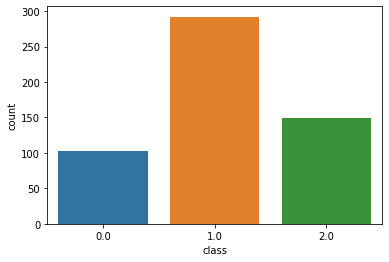

In [ ]:
import seaborn as sns
import warnings
 
warnings.simplefilter('ignore')
sns.countplot(x = "class" , data  = data_df)

In [ ]:
## посмотрим на картинки. let's look at the images

fig, axs = plt.subplots(4, 6, figsize=(16,8))
fig.suptitle(f'Нет мусорок {" "*105} Есть мусорки', fontsize=14)

rows = 4

for i, name in zip(range(rows*2), data_df[ data_df['class'] == 0 ].sample(rows*2, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)].imshow(plt.imread(f"/content/ufa/train/{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(rows*2), data_df[ data_df['class'] == 1 ].sample(rows*2, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(f"/content/ufa/train/{name}"))
    axs[i // 2, (i % 2)+2].axis('off')

for i, name in zip(range(rows*2), data_df[ data_df['class'] == 2 ].sample(rows*2, random_state=42)['ID_img']):
    print(i, i//rows, (i%2)+4)
    axs[i // 2, (i % 2)+4].imshow(plt.imread(f"/content/ufa/train/{name}"))
    axs[i // 2, (i % 2)+4].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

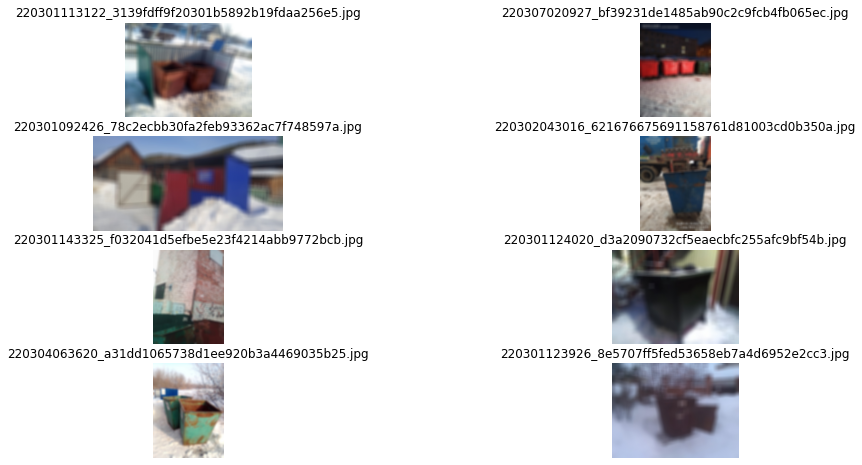

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(16,8))
for i, name in zip(range(8), c1_df.sample(8, random_state=42)['ID_img']):
  axs[i//2, (i%2)].imshow(plt.imread(f"/content/ufa/aug/{name}"))
  axs[i//2, (i%2)].axis('off')
  axs[i//2, (i%2)].set_title(f"{name}") #title.set_text(f"{name}")

In [19]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.3, random_state=43)

In [20]:
train_df.shape, valid_df.shape

((380, 2), (163, 2))

In [21]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [22]:
# Добавим два набора данных, соотвествующих размытым и затемненным изображениям
aug_dataset = AugBlurImageDataset(c1_df, train_transform)
dark_dataset = AugDarkImageDataset(dark_df, train_transform)

In [23]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=32,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

In [24]:
# Соберем набор данных из train, размытых и затемненных наборов данных
train_aug_sets = torch.utils.data.ConcatDataset([train_dataset, aug_dataset, dark_dataset])

In [25]:
# Обогащенный загрузчик данных из совокупного набора из предыдущего шага
train_aug_loader = torch.utils.data.DataLoader(dataset = train_aug_sets,
                                               batch_size=32,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=2)

## Вспомогательные функции

In [34]:
cuda = 0

In [26]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
        #val_acc = valid(res_model,criterion,optimizer,val_loader)
        #val_score.at[i] = val_acc
    
    return train_score,val_score

In [27]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [35]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    

    
    for epoch in tqdm(range(NUM_EPOCH)):
        res_model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.


        for imgs, labels in train_dataloader:

            optimizer.zero_grad()

            if cuda == 1:
              imgs = imgs.cuda()
              labels = labels.cuda()

            y_pred = res_model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        res_model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                if cuda == 1:
                  imgs = imgs.cuda()
                  labels = labels.cuda()
                
                pred = res_model(imgs)
                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred.argmax(1) == labels).sum()
        

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        #plot_history(train_loss_log, val_loss_log, 'loss')
        


        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

## Модель 1 (baseline)

In [ ]:
torch.cuda.empty_cache()

In [36]:
# Подргружаем модель

model = models.resnet50(pretrained=True)
#model.fc = nn.Linear(2048, 3)
n_inputs = model.fc.in_features
model.fc = nn.Sequential(
          nn.Linear(n_inputs, 256),
          nn.ReLU(),
          nn.Dropout(0.4),
          nn.Linear(256, 3),                   
          nn.LogSoftmax(dim=1))

if cuda == 1:
  model = model.cuda()
criterion = torch.nn.NLLLoss() #CrossEntropyLoss()

In [30]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
#train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
#                                                                 criterion, 
#                                                                optimizer, 
#                                                                 train_loader, 
#                                                                 valid_loader, 
#                                                                 15)

In [37]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
                                                                 criterion, 
                                                                optimizer, 
                                                                 train_aug_loader, 
                                                                 valid_loader, 
                                                                 15)

  0%|          | 0/15 [06:12<?, ?it/s]
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

## Посмотрим метрики нашей итоговой модели на валидации.

In [ ]:
model.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


In [ ]:
valid_df["pred"] = valid_predicts

# Посчитаем accuracy

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc , accuracy_score

In [ ]:
valid_df['pred'].values

array([1, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2,
       2, 1, 2, 1, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 0,
       2, 0, 1, 1, 2, 1, 1, 0, 2, 2, 0, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2,
       1, 2, 1, 0, 0, 2, 2, 2, 0, 0, 1, 1, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2, 2, 0, 0, 2,
       2, 1, 0, 1, 2, 2, 0, 1, 1, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 1, 2,
       1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 0, 2, 1, 0, 2,
       2, 1, 2, 0, 1, 2, 1, 1, 1])

In [ ]:
val_accuracy = accuracy_score(valid_df['class'].values, valid_df['pred'].values)
print(f"Validation accuracy = {val_accuracy}")

Validation accuracy = 0.7730061349693251


In [ ]:
classes = [0,1,2]
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = valid_df.copy()
    df_aux['class'] = [1 if y == c else 0 for y in valid_df['class']]
    df_aux['prob'] = valid_df['pred']
    df_aux = df_aux.reset_index(drop = True)
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

In [ ]:
print(roc_auc_ovr)

{0: 0.21296296296296294, 1: 0.35424242424242425, 2: 0.8652173913043478}


In [ ]:
torch.save(model.state_dict(), "resnet_model")

In [ ]:
valid_df.loc[(valid_df['class']!=valid_df['pred']) & (valid_df['class']==1)]

,ID_img,class,pred
375,220301124019_b6899a82ecd89292548cc11e712f255a.jpg,1.0,2
406,220302020709_ef606fc40122782c608aa4b0dd0cb95b.jpg,1.0,2
291,220301090918_7e51bc3af9c034f074df5f38261880cf.jpg,1.0,2
507,220307014836_5ee7bb8efe07ed736bf4941165faeb9e.jpg,1.0,2
516,220307022721_c67544b92d7d42e8b70b4bddf355416a.jpg,1.0,2
494,220306073024_e19fd6a2c1dab88da7923a0a3689d38d.jpg,1.0,2
390,220301124526_ba6ffcfd54b8a2e2d7120082abf89be8.jpg,1.0,2
471,220304031122_f4bc294df4f178c4e60b16b5f323c88c.jpg,1.0,2
477,220304063326_d00d7a35c1490bf3ce4daeb58f8eaf7e.jpg,1.0,2
296,220301092426_78c2ecbb30fa2feb93362ac7f748597a.jpg,1.0,0


## Модель 2

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Подргружаем модель

model2 = models.densenet121(pretrained=True)
#model.fc = nn.Linear(2048, 3)
n_inputs = model2.classifier.in_features
model2.classifier = nn.Sequential(
          nn.Linear(n_inputs, 256),
          nn.ReLU(),
          nn.Dropout(0.4),
          nn.Linear(256, 3),                   
          nn.LogSoftmax(dim=1))

model2 = model2.cuda()
criterion2 = torch.nn.NLLLoss() #CrossEntropyLoss()

In [ ]:
optimizer2 = torch.optim.Adam(model2.classifier.parameters(), lr=0.001)

In [ ]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model2, 
                                                                 criterion2, 
                                                                optimizer2, 
                                                                 train_aug_loader, 
                                                                 valid_loader, 
                                                                 30)

100%|██████████| 30/30 [08:50<00:00, 17.69s/it]

Train loss: 0.23529530102889443
Val loss: 1.197750647009516
Train acc: tensor(97.7178, device='cuda:0')
Val acc: tensor(82.2086, device='cuda:0')


## Посмотрим метрики нашей итоговой модели на валидации.

In [ ]:
model2.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.cuda()
    pred = model2(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


In [ ]:
valid_df["pred"] = valid_predicts

# Посчитаем accuracy

In [ ]:
val_accuracy = accuracy_score(valid_df['class'].values, valid_df['pred'].values)
print(f"Validation accuracy = {val_accuracy}")

Validation accuracy = 0.0


In [ ]:
classes = [0,1,2]
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = valid_df.copy()
    df_aux['class'] = [1 if y == c else 0 for y in valid_df['class']]
    df_aux['prob'] = valid_df['pred']
    df_aux = df_aux.reset_index(drop = True)
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

In [ ]:
print(roc_auc_ovr)

{0: 0.16040305010893247, 1: 0.3384090909090909, 2: 0.9191123188405796}


In [ ]:
torch.save(model2.state_dict(), "densenet_model")

In [ ]:
valid_df.loc[(valid_df['class']!=valid_df['pred']) & (valid_df['class']==1)]

,ID_img,class,pred
375,220301124019_b6899a82ecd89292548cc11e712f255a.jpg,1.0,0
406,220302020709_ef606fc40122782c608aa4b0dd0cb95b.jpg,1.0,2
291,220301090918_7e51bc3af9c034f074df5f38261880cf.jpg,1.0,0
494,220306073024_e19fd6a2c1dab88da7923a0a3689d38d.jpg,1.0,0
390,220301124526_ba6ffcfd54b8a2e2d7120082abf89be8.jpg,1.0,2
471,220304031122_f4bc294df4f178c4e60b16b5f323c88c.jpg,1.0,2
477,220304063326_d00d7a35c1490bf3ce4daeb58f8eaf7e.jpg,1.0,2
535,220307080853_db633c7e47674dd3b697915aaaca60b3.jpg,1.0,0
398,220301150606_a360a2f28eacd5648732c9a28c1e4c0a.jpg,1.0,2
462,220303054740_9daab175576b21466a151bc4b9a0536f.jpg,1.0,2


## Модель 3

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Подргружаем модель

model3 = models.vgg16_bn(pretrained=True)
#model.fc = nn.Linear(2048, 3)
n_inputs = model3.classifier[6].in_features
model3.classifier[6] = nn.Sequential(
          nn.Linear(n_inputs, 256),
          nn.ReLU(),
          nn.Dropout(0.4),
          nn.Linear(256, 3),                   
          nn.LogSoftmax(dim=1))

model3 = model3.cuda()
criterion3 = torch.nn.NLLLoss() #CrossEntropyLoss()

In [ ]:
optimizer3 = torch.optim.Adam(model3.classifier[6].parameters(), lr=0.001)

In [ ]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model3, 
                                                                 criterion3, 
                                                                optimizer3, 
                                                                 train_aug_loader, 
                                                                 valid_loader, 
                                                                 30)

100%|██████████| 30/30 [10:05<00:00, 20.18s/it]

Train loss: 0.3361358173979887
Val loss: 1.2893857674364664
Train acc: tensor(96.3693, device='cuda:0')
Val acc: tensor(84.0491, device='cuda:0')


## Посмотрим метрики нашей итоговой модели на валидации.

In [ ]:
model3.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.cuda()
    pred = model3(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

100%|██████████| 6/6 [00:03<00:00,  1.99it/s]


In [ ]:
valid_df["pred"] = valid_predicts

# Посчитаем accuracy

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc , accuracy_score

In [ ]:
valid_df['pred'].values

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 2, 2, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1,
       1, 1, 2, 1, 0, 1, 2, 2, 0, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1,
       1, 0, 1, 1, 2, 1, 1, 0, 2, 2, 0, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2,
       1, 2, 1, 0, 0, 1, 2, 0, 0, 0, 1, 1, 2, 1, 2, 0, 1, 1, 2, 2, 2, 2,
       2, 1, 0, 0, 2, 2, 2, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2, 2, 0, 0, 1,
       2, 1, 0, 1, 2, 1, 0, 1, 1, 2, 0, 2, 1, 0, 1, 2, 2, 2, 2, 2, 1, 2,
       1, 2, 1, 2, 1, 1, 2, 1, 2, 0, 2, 2, 1, 1, 1, 1, 2, 0, 0, 1, 0, 2,
       2, 1, 2, 0, 1, 1, 1, 1, 1])

In [ ]:
val_accuracy = accuracy_score(valid_df['class'].values, valid_df['pred'].values)
print(f"Validation accuracy = {val_accuracy}")

Validation accuracy = 0.8404907975460123


In [ ]:
classes = [0,1,2]
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = valid_df.copy()
    df_aux['class'] = [1 if y == c else 0 for y in valid_df['class']]
    df_aux['prob'] = valid_df['pred']
    df_aux = df_aux.reset_index(drop = True)
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

In [ ]:
print(roc_auc_ovr)

{0: 0.0980392156862745, 1: 0.3721969696969697, 2: 0.9201992753623187}


In [ ]:
torch.save(model3.state_dict(), "vgg_model")

In [ ]:
valid_df.loc[(valid_df['class']!=valid_df['pred']) & (valid_df['class']==1)]

,ID_img,class,pred
375,220301124019_b6899a82ecd89292548cc11e712f255a.jpg,1.0,0
406,220302020709_ef606fc40122782c608aa4b0dd0cb95b.jpg,1.0,2
390,220301124526_ba6ffcfd54b8a2e2d7120082abf89be8.jpg,1.0,2
471,220304031122_f4bc294df4f178c4e60b16b5f323c88c.jpg,1.0,2
477,220304063326_d00d7a35c1490bf3ce4daeb58f8eaf7e.jpg,1.0,2
535,220307080853_db633c7e47674dd3b697915aaaca60b3.jpg,1.0,0
462,220303054740_9daab175576b21466a151bc4b9a0536f.jpg,1.0,2
397,220301150603_c16cfd04d0e3eed75e084d3691baef6e.jpg,1.0,0
502,220307011013_2cf5d2c7334a82feac79dd3560fee8d5.jpg,1.0,2
465,220303083251_9d40ea68b764c82e62fedf62d0a24884.jpg,1.0,0


## Ансамбль моделей

In [ ]:
import torch.nn.functional as F

In [ ]:
class Ensemble1(nn.Module):
  def __init__(self, model1, model2, model3, n_classes=3):
    super(Ensemble1, self).__init__()
    self.model1 = model1
    self.model2 = model2
    self.model3 = model3
    self.model1.fc = nn.Identity()
    self.model2.classifier = nn.Identity()
    self.model3.classifier[6] = nn.Identity()
#    self.classifier = nn.Sequential(
#          nn.Linear(2048+1024+4096, 256),
#          nn.ReLU(),
#          nn.Dropout(0.4),
#          nn.Linear(256, 3),                   
#          nn.LogSoftmax(dim=1))
    self.classifier = nn.Linear(2048+1024+4096, n_classes)

  def forward(self, x):
    x1 = self.model1(x.clone())
    x1 = x1.view(x1.size(0), -1)
    x2 = self.model2(x.clone())
    x2 = x2.view(x2.size(0), -1)
    x3 = self.model3(x.clone())
    x3 = x3.view(x3.size(0), -1)

    x = torch.cat((x1, x2, x3), dim=1)
    x = self.classifier(F.relu(x))

    return x

In [ ]:
class Ensemble3(nn.Module):
  def __init__(self, model1, model2, model3, n_classes=3):
    super(Ensemble3, self).__init__()
    self.model1 = model1
    self.model2 = model2
    self.model3 = model3

    #self.model1.classifier = nn.Identity()
    #self.model2.classifier = nn.Identity()
    #self.model3.classifier = nn.Identity()
    self.classifier = nn.Linear(9, n_classes)

  def forward(self, x):
    x1 = self.model1(x.clone())
    x1 = x1.view(x1.size(0), -1)

    x2 = self.model2(x.clone())
    x2 = x2.view(x2.size(0), -1)

    x3 = self.model3(x.clone())
    x3 = x3.view(x3.size(0), -1)

    x = torch.cat((x1, x2, x3), dim=1)
    x = self.classifier(F.relu(x))

    return x

In [ ]:
for param in model.parameters():
  param.requires_grad_(False)

for param in model2.parameters():
  param.requires_grad_(False)

for param in model3.parameters():
  param.requires_grad_(False)


In [ ]:
model_e1 = Ensemble1(model, model2, model3,3)
model_e1 = model_e1.cuda()

In [ ]:
model

In [ ]:
model_e = Ensemble3(model, model2, model3, 3)
model_e = model_e.cuda()


In [ ]:
optimizer_e = torch.optim.Adam(model_e1.parameters(), lr=0.001)

In [ ]:
#criterion_e = torch.nn.NLLLoss() #torch.nn.CrossEntropyLoss()
criterion_e = torch.nn.CrossEntropyLoss()

In [ ]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model_e1, 
                                                                 criterion_e, 
                                                                optimizer_e, 
                                                                 train_aug_loader, 
                                                                 valid_loader, 
                                                                 15)

100%|██████████| 15/15 [04:51<00:00, 19.41s/it]

Train loss: 0.26287007608346613
Val loss: 1.3497237276080196
Train acc: tensor(97.0954, device='cuda:0')
Val acc: tensor(84.6626, device='cuda:0')


## Посмотрим метрики нашей итоговой модели на валидации.

In [ ]:
model_e1.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.cuda()
    pred = model_e1(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

100%|██████████| 6/6 [00:03<00:00,  1.75it/s]


In [ ]:
valid_df["pred"] = valid_predicts

# Посчитаем accuracy

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc , accuracy_score

In [ ]:
valid_df['pred'].values

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 2, 2, 1, 1, 0, 1, 0, 2, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 2, 2, 0, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1,
       1, 0, 1, 1, 2, 1, 1, 0, 2, 2, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2,
       1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 2, 2,
       2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2, 2, 0, 0, 1,
       2, 1, 0, 1, 2, 1, 0, 1, 1, 2, 2, 2, 1, 0, 1, 2, 0, 2, 2, 2, 1, 2,
       1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 1, 0, 2,
       2, 1, 2, 0, 1, 1, 1, 1, 1])

In [ ]:
val_accuracy = accuracy_score(valid_df['class'].values, valid_df['pred'].values)
print(f"Validation accuracy = {val_accuracy}")

Validation accuracy = 0.8466257668711656


In [ ]:
classes = [0,1,2]
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = valid_df.copy()
    df_aux['class'] = [1 if y == c else 0 for y in valid_df['class']]
    df_aux['prob'] = valid_df['pred']
    df_aux = df_aux.reset_index(drop = True)
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

In [ ]:
print(roc_auc_ovr)

{0: 0.13902505446623098, 1: 0.3507575757575757, 2: 0.9185688405797101}


## Предскажем для теста

In [ ]:
from tqdm import tqdm
import os
import pathlib

In [ ]:
test_df = pd.read_csv("/content/ufa/sample_solution.csv")
test_df = test_df.drop(["class"], axis = 1)

In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['ID_img']
        
        # определяем полное имя
        fname = glob.glob(os.path.join('/content/ufa/test/', f"{image_name}.*"))[0]
        # читаем картинку
        # image = cv2.imread(f"/content/ufa/test/{image_name}.jpg")
        image = cv2.imread(fname)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.data_df)

In [ ]:
test_dataset = TestImageDataset(test_df, valid_transform)

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

#Предсказываем нашей моделью результат

In [ ]:
model2 = models.densenet121(pretrained=True)
#model.fc = nn.Linear(2048, 3)
n_inputs = model2.classifier.in_features
model2.classifier = nn.Sequential(
          nn.Linear(n_inputs, 256),
          nn.ReLU(),
          nn.Dropout(0.4),
          nn.Linear(256, 3),                   
          nn.LogSoftmax(dim=1))

model2 = model2.cuda()
criterion2 = torch.nn.NLLLoss() #CrossEntropyLoss()
model2.load_state_dict(torch.load("densenet_model"))
model2.eval()

In [ ]:
model_e1.eval()
predicts = []
test_names = []

for imgs in tqdm(test_loader):

    
    imgs = imgs.cuda()
    pred = model_e1(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      predicts.append(index)
    
    #predicts.append(pred.softmax(dim=1)[:, 1].cpu().detach().numpy()) # argmax(dim=1)

100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


In [ ]:
test_df

,ID_img
0,34020749806_42065966214_42113475048_2
1,80128313599_98196458454_79029076007_8
2,17820331238_48919943775_53688855463_7
3,70492442702_21083599816_22777758696_0
4,94790217016_17108156014_60668676818_2
...,...
220,60879177998_15763718934_82574532042_2
221,11758169966_65799840524_72283028069_1
222,9259096884_2251720133_44072689872_8
223,37732252922_9265441355_19052721018_3


In [ ]:
test_names = test_df["ID_img"]

In [ ]:
submit_df = pd.DataFrame([[name, pred] for name, pred in zip(test_names, predicts)], columns=['ID_img', 'class'])

In [ ]:
submit_df

,ID_img,class
0,34020749806_42065966214_42113475048_2,2
1,80128313599_98196458454_79029076007_8,1
2,17820331238_48919943775_53688855463_7,2
3,70492442702_21083599816_22777758696_0,2
4,94790217016_17108156014_60668676818_2,1
...,...,...
220,60879177998_15763718934_82574532042_2,2
221,11758169966_65799840524_72283028069_1,1
222,9259096884_2251720133_44072689872_8,0
223,37732252922_9265441355_19052721018_3,1


In [ ]:
submit_df.to_csv("submit1.csv", index=False)